# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [36]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [37]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2020-10-01,3221.260010,24.100000,358.459991,123.309998,426.989990,49.180000,219.589996,212.460007,3.53,86.739998
2020-10-02,3125.000000,24.209999,355.010010,122.550003,433.779999,49.360001,222.669998,206.190002,3.54,86.570000
2020-10-05,3199.199951,24.620001,358.579987,123.370003,424.940002,49.380001,226.070007,210.380005,3.69,88.470001
2020-10-06,3099.959961,24.370001,358.350006,120.930000,427.529999,48.939999,224.089996,205.910004,3.54,87.010002
2020-10-07,3195.689941,24.879999,363.019989,122.910004,431.049988,49.560001,226.479996,209.830002,3.55,88.449997


In [38]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.079659
1993-02-01    26.265144
1993-02-02    26.320782
1993-02-03    26.599014
1993-02-04    26.710312
Name: Adj Close, dtype: float64

In [39]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1587919978496,
 'AMZN': 1600689143808,
 'NAT': 531399488,
 'BAC': 215562797056,
 'DPZ': 16960610304,
 'DIS': 222105747456,
 'KO': 212881997824,
 'MCD': 168524431360,
 'COST': 160184385536,
 'SBUX': 103398039552}

## Constructing the prior

In [40]:
import pypfopt
pypfopt.__version__

'1.2.5'

In [41]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5373398520494828

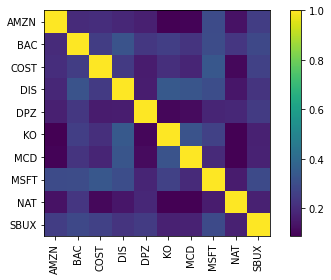

In [42]:
plotting.plot_covariance(S, plot_correlation=True);

In [43]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.189376
BAC     0.098945
COST    0.073436
DIS     0.091687
DPZ     0.046768
KO      0.061366
MCD     0.066636
MSFT    0.125875
NAT     0.050824
SBUX    0.078081
dtype: float64

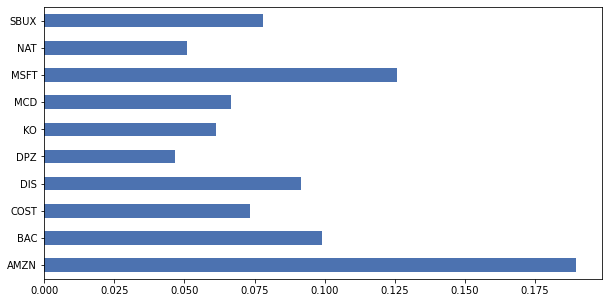

In [44]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [45]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [46]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [47]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

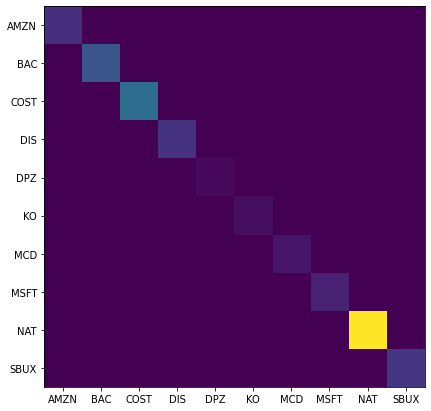

In [48]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [49]:
np.diag(bl.omega)

array([0.00459732, 0.00904256, 0.01214591, 0.00497577, 0.0008033 ,
       0.00125604, 0.00197181, 0.00344841, 0.03412767, 0.0053853 ])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [50]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [51]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estiamte of returns


In [52]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison="delta",
                        absolute_views=viewdict, omega=omega)

In [53]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.112644
BAC     0.147890
COST    0.052249
DIS     0.066569
DPZ     0.099977
KO      0.002481
MCD     0.106133
MSFT    0.094685
NAT     0.062031
SBUX    0.075472
dtype: float64

We can visualise how this compares to the prior and our views:

In [54]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.189376,0.112644,0.10
BAC,0.098945,0.147890,0.30
COST,0.073436,0.052249,0.05
DIS,0.091687,0.066569,0.05
DPZ,0.046768,0.099977,0.20
KO,0.061366,0.002481,-0.05
MCD,0.066636,0.106133,0.15
MSFT,0.125875,0.094685,0.10
NAT,0.050824,0.062031,0.50
SBUX,0.078081,0.075472,0.10


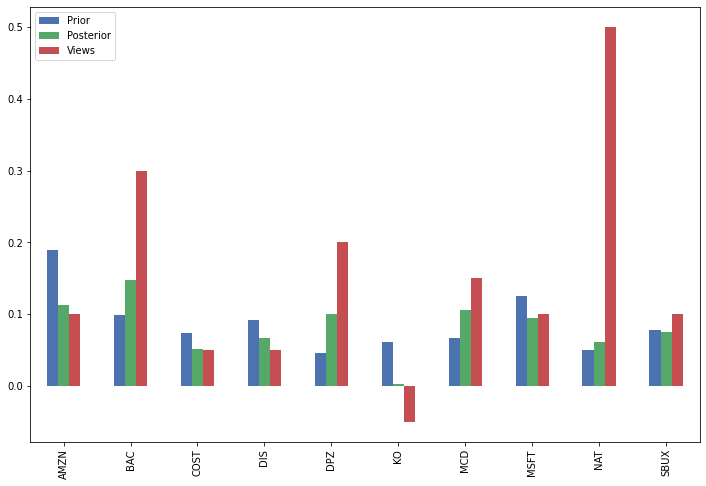

In [55]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is always between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

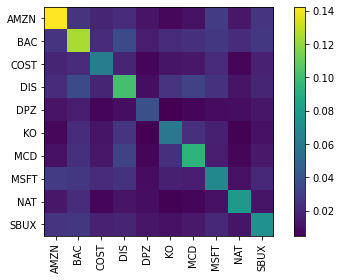

In [56]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [57]:
from pypfopt import EfficientFrontier, objective_functions

In [66]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AMZN', 0.09361),
             ('BAC', 0.09002),
             ('COST', 0.10322),
             ('DIS', 0.09399),
             ('DPZ', 0.1105),
             ('KO', 0.10447),
             ('MCD', 0.09966),
             ('MSFT', 0.0993),
             ('NAT', 0.10507),
             ('SBUX', 0.10016)])

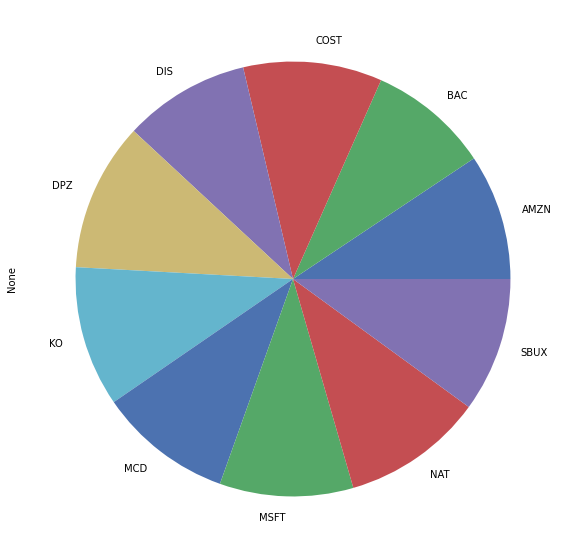

In [67]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [60]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.06


{'AMZN': 1,
 'BAC': 163,
 'COST': 2,
 'DIS': 10,
 'DPZ': 6,
 'MCD': 13,
 'MSFT': 11,
 'NAT': 359,
 'SBUX': 19}